In [123]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XY as std

In [124]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [125]:
SEED = 314
NUM_SHOTS = 256
np.random.seed(SEED)

In [126]:
# setup the datagen model
max_fogi_error_rate = 0.01
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [127]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.012967810748420183
mean square error:  0.0005550742625963212


In [128]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [129]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  56 circuits ---
Iterative GST Total Time: 0.4s
--- Iterative GST: [##################################################] 100.0%  96 circuits ---
Iterative GST Total Time: 0.6s
--- Iterative GST: [##################################################] 100.0%  177 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  304 circuits ---
Iterative GST Total Time: 1.1s


In [138]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

germ_length_ranges = {
    0: [0, 56], 
    1: [56, 96], 
    2: [96, 177], 
    3: [177, 304]
}

In [131]:
# run a Kalman filter in the usual way
prior_covar = 0.001*np.eye(target_model.num_params)
usual_post_model, usual_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:16<00:00, 18.39it/s]


In [132]:
usual_parameter_history = saved_data[0]
usual_covar_history = saved_data[1]

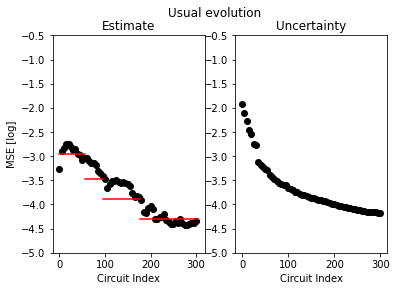

In [139]:
%matplotlib inline
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Usual evolution', usual_parameter_history, mdl_datagen.to_vector(), usual_covar_history, yrange, mle_estimates, germ_length_ranges, plt_spacing)

In [134]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

In [135]:
model = target_model
P = 0.001*np.eye(target_model.num_params)
circ_list = edesign.circuit_lists[-1]

In [136]:
def fx(x, dt):
    return x

def model_wrapper(x_state, circ, model):
    model.from_vector(x_state)
    return vector_from_outcomes(model.probabilities(circ), 2**circ.width)

model = target_model
P = 0.1*np.eye(model.num_params)

dt = 1
points = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = model.copy()

ukf.x = target_model.to_vector()
ukf.P = P

In [137]:
ukf_model_vectors = dict()
ukf_covars = dict()

idx = 0
ukf_model_vectors[idx] = ukf.x
ukf_covars[idx] = ukf.P
idx += 1

# run over the largest set of GST circuits
for circ in tqdm(circ_list):
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = cvec/sum(cvec)
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior
    
    R_obs = categorical_covar(freq)/sum(cvec)
    ukf.predict()
    ukf.update(freq, R=R_obs+R_add, circ=circ, model=ukf_filter_model)
    
    #kgain = ekf.update_approx(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, Q_add, R_add)
    
    
    ukf_model_vectors[idx] = ukf.x
    ukf_covars[idx] = ukf.P

    idx += 1
num_circs = idx

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:38<00:00,  7.93it/s]


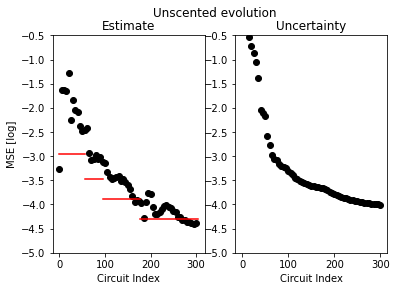

In [140]:
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Unscented evolution', ukf_model_vectors, mdl_datagen.to_vector(), ukf_covars, yrange, mle_estimates, germ_length_ranges, plt_spacing)

# The sigmapoint score function
We'll create a score function motivated by mutual information, since the entropy of a gaussian r.v. is
$$
    H(x \sim \mathcal{N}(\mu, \Sigma) ) = \frac{D}{2}(1 + \log(2 \pi)) + \frac{1}{2} \log |\Sigma|
$$
where $|\Sigma| = \det(\Sigma)$

Let $(X, Y) \sim \mathcal{N}( (\bar{X}, \bar{Y}), \Sigma)$ where
$$
    \Sigma = \begin{bmatrix} \Sigma_X & \Sigma_{XY} \\ \Sigma_{YX} & \Sigma_{Y} \end{bmatrix}
$$
and consider
$$
    I(X;Y) = H(X) + H(Y) - H(X, Y)
$$ 
Given a prior $X$ and a prediction $Y$, the mutual informaiton is
$$
     \frac{1}{2} \log \frac{|\Sigma_Y||\Sigma_X| }{|\Sigma_{XY}|}
$$
Since the determinant is really just the product of eigenvalues, we'll calculate the eigenvalues and then discard those above a cutoff


In [141]:
def make_joint_vectors(circ, model, model_covar, sigma_point_def):
    """
    make a set of joint samples of the form (X, Y) where X is the sigma point and Y is its prediction
    """
    sigma_points = sigma_point_def.sigma_points(model.to_vector(), P)
    
    fid_model = model.copy()
    joint_vectors = []
    for idx, x in enumerate(sigma_points):
        fid_model.from_vector(x)
        pred = vector_from_outcomes(fid_model.probabilities(circ), 2**circ.width)
        joint_vectors.append(np.hstack([x, pred]))
    return joint_vectors

def make_joint_covar(circ, model, model_covar, sigma_point_def):
    """
    make the joint covar 
    """
    jvs = make_joint_vectors(circ, model, P, sigma_point_def)

    mean_weights = sigma_point_def.Wm
    jv_mean = sum([mean_weights[i]*jvs[i] for i in range(len(mean_weights))])
    jv_covar = sum([
        sigma_point_def.Wc[i]*
        np.outer(jvs[i] - jv_mean, jvs[i] - jv_mean)
        for i in range(len(mean_weights))
    ])
    return jv_covar

def sigma_XY(joint_covar, num_params, hdims):
    assert joint_covar.shape[0] == num_params+hdims
    return joint_covar[0:num_params, num_params::]

def sigma_YY(joint_covar, num_params, hdims):
    assert joint_covar.shape[0] == num_params+hdims
    return joint_covar[num_params::, num_params::]

def sigma_XX(joint_covar, num_params, hdims):
    assert joint_covar.shape[0] == num_params+hdims
    return joint_covar[0:num_params, 0:num_params]

In [142]:
def nonlinear_violation(sigmaX, sigmaY, jac, eigen_cutoff=1e-6):
    
    
    
    sigY_eigs = [e for e in np.linalg.eigvals(sigmaX) if e > eigen_cutoff]

In [212]:
def score_covar(joint_covar, eigen_cutoff=1e-6, jac=None):
    """
    add in nonlinear violation if a jacobian is given 
    """
    sigYY = sigma_YY(joint_covar, model.num_params, 2**circ.width)
    sigXX = sigma_XX(joint_covar, model.num_params, 2**circ.width)
    
    sigYY_eigs = [e for e in np.linalg.eigvals(sigYY) if e > eigen_cutoff]
    sigXX_eigs = [e for e in np.linalg.eigvals(sigXX) if e > eigen_cutoff]
    joint_eigs = [e for e in np.linalg.eigvals(joint_covar) if e > eigen_cutoff]
    
    if jac is None:
        nonlin_violation = 1
    else: 
        nonlin_eigs = np.linalg.eigvals(sigYY - jac@sigXX@jac.T)
        nonlin_violation = 1+sum(abs(nonlin_eigs))
        print(nonlin_violation)
       
    
     
    
    det_sigXX = np.prod(sigXX_eigs)
    det_sigYY = np.prod(sigYY_eigs)
    det_joint = np.prod(joint_eigs)
    
    return 0.5*np.log2((det_sigXX*det_sigYY)/(det_joint*nonlin_violation))

In [213]:
model = target_model
P = 0.1*np.eye(model.num_params)

dt = 1
sigma_point_def = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = model.copy()

ukf.x = target_model.to_vector()
ukf.P = P

In [214]:
def score_circuit_list(circ_list, model, model_covar,
                       sigma_point_def, eigen_cutoff=1e-6, nonlin_violation=False):
    scores = dict()
    for circ in tqdm(circ_list):
        if nonlin_violation is True:
            jac = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
        else:
            jac = None
        joint_covar = make_joint_covar(circ, model, model_covar, sigma_point_def)
        scores[circ] = score_covar(joint_covar, eigen_cutoff, jac)
    return scores

In [215]:
def find_best_scoring_circuit(circ_list, model, model_covar,
                       sigma_point_def, eigen_cutoff=1e-6, nonlin_violation=False):
    
    scores = score_circuit_list(circ_list, model, model_covar, sigma_point_def, eigen_cutoff, nonlin_violation)
    best_score = max(scores.values())
    best_circuits = [key for key in scores if scores[key] == best_score]
    return best_circuits[0], scores

In [216]:
circ_list = edesign.circuit_lists[0]
best_circ, scores = find_best_scoring_circuit(circ_list, model, P, sigma_point_def, nonlin_violation=True)

  5%|██████████▊                                                                                                                                                                                              | 3/56 [00:00<00:04, 10.83it/s]

2.0052367967165927
1.0084068246692355
1.0084068246692377


  9%|█████████████████▉                                                                                                                                                                                       | 5/56 [00:00<00:04, 10.20it/s]

1.7364349052173544
1.170571763024243


 12%|█████████████████████████▏                                                                                                                                                                               | 7/56 [00:00<00:04,  9.98it/s]

1.1705717630242447
1.0169158653551986


 16%|████████████████████████████████▎                                                                                                                                                                        | 9/56 [00:00<00:05,  9.10it/s]

3.1041728742835346
1.0169509848560114


 18%|███████████████████████████████████▋                                                                                                                                                                    | 10/56 [00:01<00:04,  9.29it/s]

1.0169158653551984
1.7364349052172905


 23%|██████████████████████████████████████████████▍                                                                                                                                                         | 13/56 [00:01<00:04,  9.12it/s]

1.0087825449725913
1.0169509848560114


 27%|█████████████████████████████████████████████████████▌                                                                                                                                                  | 15/56 [00:01<00:04,  8.80it/s]

3.1041728742835213
1.0087825449725885


 30%|████████████████████████████████████████████████████████████▋                                                                                                                                           | 17/56 [00:01<00:04,  8.00it/s]

2.4085496769817345
1.170951742097136


 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                    | 19/56 [00:02<00:04,  7.64it/s]

1.0169509848560114
19.658060083366507


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                             | 21/56 [00:02<00:04,  7.63it/s]

1.0169810489930975
1.0169509848560114


 41%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 23/56 [00:02<00:04,  7.44it/s]

1.1709517420971312
1.0169810489930968


 45%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 25/56 [00:02<00:04,  7.75it/s]

19.658060083366436
1.4580040654863522


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 27/56 [00:03<00:03,  7.67it/s]

1.008334223387126
4.013436187540707


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 29/56 [00:03<00:03,  7.23it/s]

1.008334223387124
5.945186336222123


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 31/56 [00:03<00:03,  7.09it/s]

1.170516195392644
4.0134361875407745


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 33/56 [00:04<00:03,  6.77it/s]

1.1705161953926484
43.02254295323909


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 35/56 [00:04<00:02,  7.76it/s]

1.4580040654864
1.0087825449725911


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 37/56 [00:04<00:02,  7.79it/s]

1.0668887065695554
4.013436187540785


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 39/56 [00:04<00:02,  8.05it/s]

1.0083342233871242
1.008782544972585


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 41/56 [00:05<00:01,  7.88it/s]

1.5674042385526947
1.1709517420971287


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 43/56 [00:05<00:01,  7.98it/s]

2.408549676981722
1.066888706569548




KeyboardInterrupt



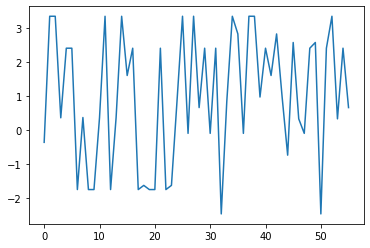

In [202]:
plt.plot(scores.values())

In [203]:
best_circ

Circuit(Gypi2:0(Gxpi2:0)Gxpi2:0Gxpi2:0Gxpi2:0@(0))

# example

warm start on germ1 then search germ2 circuits

In [207]:
# run a Kalman filter in the usual way
prior_covar = 0.001*np.eye(target_model.num_params)
germ1_circuits = edesign.circuit_lists[0]
germ1_post_model, germ1_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, germ1_circuits, 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 25.52it/s]


In [209]:
# setup the sigma point filter
model = germ1_post_model
P = germ1_post_covar

circ_list = edesign.circuit_lists[1]

dt = 1
sigma_point_def = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = model.copy()

ukf.x = target_model.to_vector()
ukf.P = P

fid_model = target_model.copy()

adaptive_parameter_history = []
adaptive_covar_history = []
adaptive_parameter_history.append(ukf.x)
adaptive_covar_history.append(ukf.P)  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:10<00:00,  9.15it/s]

MSE:  0.0005550742625963212
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted score:  2.2067979929014867


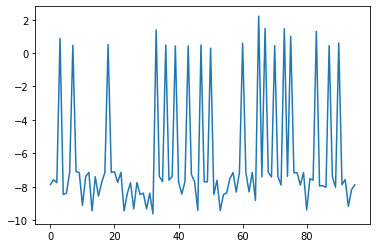

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:10<00:00,  9.30it/s]


MSE:  0.0006268294247179146
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted score:  2.2067979929014867


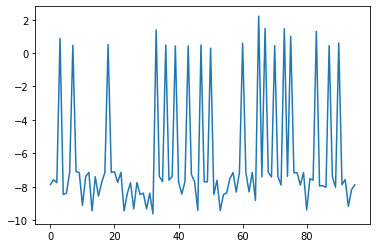

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:10<00:00,  9.25it/s]

MSE:  0.0007161419877082456
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted score:  2.2067979929014867


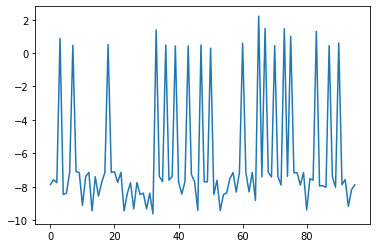

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:10<00:00,  9.25it/s]

MSE:  0.000773901880647839
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted score:  2.2067979929014867


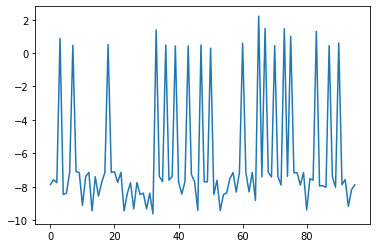

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:10<00:00,  9.28it/s]

MSE:  0.0008133290285322819
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted score:  2.2067979929014867


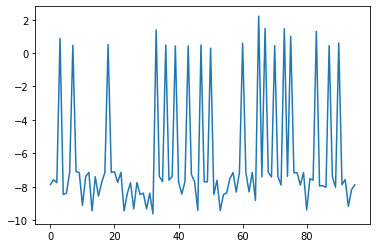

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:10<00:00,  9.25it/s]


MSE:  0.00084182540655375
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted score:  2.2067979929014867


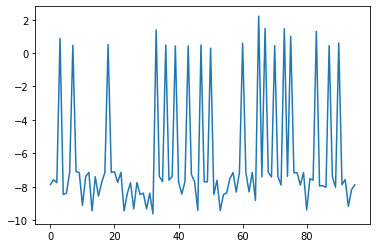

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:10<00:00,  8.92it/s]


MSE:  0.0008633619575359028
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted score:  2.2067979929014867


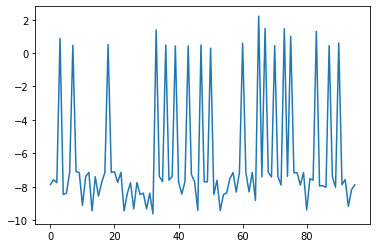

 11%|██████████████████████▉                                                                                                                                                                                 | 11/96 [00:01<00:07, 10.63it/s]

KeyboardInterrupt



In [210]:
# now swtich to adaptive filtering with sigma-point updates
num_updates = 10
show_output = True

current_update = 0
while(current_update < num_updates):
    fid_model.from_vector(ukf.x)
    circ, scores = find_best_scoring_circuit(circ_list, model, P, sigma_point_def)
    if show_output:
        print('MSE: ', mserror(fid_model, mdl_datagen))
        print('Best circ: ', circ)
        print('Predicted score: ', scores[circ])

        plt.plot(scores.values())
        plt.show()
    else:
        # show progress if not output
        # pbar.update(1)
        pass
        
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = (cvec+np.ones(len(cvec)))/(sum(cvec) + len(cvec))
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior
    
    R_obs = categorical_covar(freq)/sum(cvec)
    ukf.predict()
    ukf.update(freq, R=R_obs+R_add, circ=circ, model=ukf_filter_model)
    adaptive_parameter_history.append(ukf.x)
    adaptive_covar_history.append(ukf.P)    
    
    current_update += 1
pbar.close()

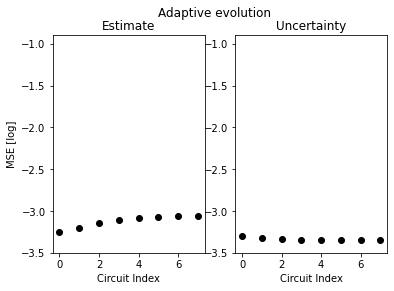

In [211]:
yrange = [-3.5, -0.9]
make_error_plot('Adaptive evolution', adaptive_parameter_history, mdl_datagen.to_vector(), adaptive_covar_history, yrange, None, germ_length_ranges, 1)

# regularization 
or
$$
     \frac{1}{2} \log \frac{|\Sigma_Y| }{|\Sigma_X - \Sigma_{XY} \Sigma_{Y}^{-1} \Sigma_{YX}|}
$$
or
$$
     \frac{1}{2} \log \frac{|\Sigma_X| }{|\Sigma_Y - \Sigma_{YX} \Sigma_{X}^{-1} \Sigma_{XY}|}
$$


Use sigma points to calculate 
$$
    \Sigma_Y = \sum_i w_i (h(x^{(i)}) - \bar{h}) (h(x^{(i)}) - \bar{h})^T
$$
and the nonlinear violation can be seen as a norm of  
$$
    \Sigma - H P H^T
$$

Finally, the score function is defined: 
$$
     \frac{1}{2} \log \frac{|\Sigma_X| }{|R_k + \Sigma_Y^{(k)} -  H_k \Sigma_X H_k^T|}
$$

We can exclude small propre values by removing the singular values from $\Sigma_X$ 

# a simple score function 

We'll compare the the ratio of the product of the largest N eigenvalues of the prior and posterior $P$ to pick the best circuit

The Kalman update for the covariance is
$$ P_\text{post} = (1 - K_k H_k) P_\text{prior} $$
where the Kalman gain is 
$$ K_k = P_\text{prior} H_k^T (H_k P_{\text{prior}} H_k^T + R_k)^{-1} $$

To estimate circuit shot noise, we'll use a pseduo-count vector:
$$ 
    \vec{\alpha} = N \vec{p}_\text{estimate} + \vec{1}
$$
and the covariance
$$
    R_k = \frac{1}{N+d+1} \bigg( \frac{\text{diag}( \vec{\alpha}) }{N+d} - \frac{ \alpha \alpha^T}{(N+d)^2} \bigg)
$$

In [23]:
def largest_n_evals(matrix, num_evals):
    evals = np.linalg.eigvals(matrix)
    sorted_evals = np.argsort(evals)
    return sorted_evals[0:num_evals]

In [32]:
def find_best_circuit(circ_list, model, covar, num_shots, num_evals=10):
    """
    The simpliest function to find the best next circuit
        
    We estimate the observation noise for each circuit using the filter's prediction
    
    The algo is to go through each circuit and assign a score per:
        1) estimate the sampling noise
        2) calculate the model jacobian
        3) calculate the kgain
        4) assign a score as the ratio of the largest n evals of the prior and posterior
    Pick the smallest score
    """
    prior_score = np.prod(largest_n_evals(covar, num_evals))
    ratios = dict()
    for circ in tqdm(circ_list):
        hdims = 2**circ.width
        # simulate circuit probs
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        # estimate sampling covar
        pseudo_counts = num_shots*p_model + np.ones(hdims)
        sampling_covar = (1/(num_shots + hdims + 1)) * (
            np.diag(pseudo_counts)/(num_shots + hdims) + 
            np.outer(pseudo_counts, pseudo_counts)/(num_shots + hdims)**2
        )
        # calculate kgain
        jac = matrix_from_jacob(model.sim.dprobs(circ), hdims) 
        kgain = covar@jac.T@np.linalg.pinv(jac@covar@jac.T + sampling_covar)
        # find the resulting posterior covariance
        post_covar = (np.eye(covar.shape[0]) - kgain@jac)@covar
        post_score = np.prod(largest_n_evals(covar, num_evals))
        ratios[circ] = np.log(prior_score) - np.log(post_score)
    best_score = max(ratios.values())
    best_circuits = [key for key in ratios if ratios[key] == best_score]
    return best_circuits[0], ratios

In [33]:
find_best_circuit(circ_list, target_model, P, 256, num_evals=3)

  0%|                                                                                                                                                                                                                | 0/874 [00:00<?, ?it/s]/tmp/ipykernel_25234/165580232.py:32: RuntimeWarning: divide by zero encountered in log
  ratios[circ] = np.log(prior_score) - np.log(post_score)
/tmp/ipykernel_25234/165580232.py:32: RuntimeWarning: invalid value encountered in double_scalars
  ratios[circ] = np.log(prior_score) - np.log(post_score)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [00:42<00:00, 20.39it/s]


IndexError: list index out of range